In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from integration.integrate import *

In [2]:
@jit(nopython=True)
def f(x,t,omega=2.,gamma = 0.1):
    X, Y = x
    return np.array([[-gamma, omega],[-omega,-gamma]]).dot(x)

@jit(nopython=True)
def g(x,t):
    return np.zeros((2,2))

@jit(nopython=True)
def f_cubic(x,t,omega=2.,gamma = 0.1):
    X, Y = x
    return np.array([[-gamma, omega],[-omega,-gamma]]).dot(x**3)

In [3]:
ti,tf,dt = 0,25,0.005
times = np.arange(ti,tf,dt)
x0=np.array([2.,0.])
xx1 = integrate(f,g,x0,times,dt,mode="RK4")
xx1_cubic = integrate(f_cubic,g,x0,times,dt,mode="RK4")


/home/mbilkis/OneDrive/digital-brain/RESEARCH/Sindy/integration/steps.py:33: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  k1 = dt*f(x1,t) + np.sqrt(q1)*g(x1,t).dot(dw)


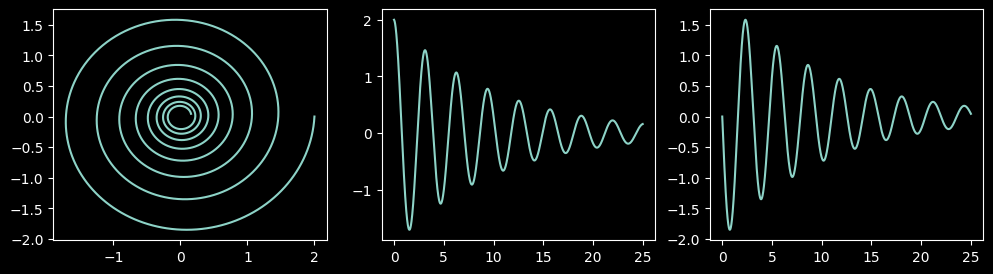

In [4]:
plt.figure(figsize=(12,3))
ax = plt.subplot(131)
ax.plot(xx1[0,:], xx1[1,:])
ax = plt.subplot(132)
ax.plot(times, xx1[0,:])
ax = plt.subplot(133)
ax.plot(times, xx1[1,:])

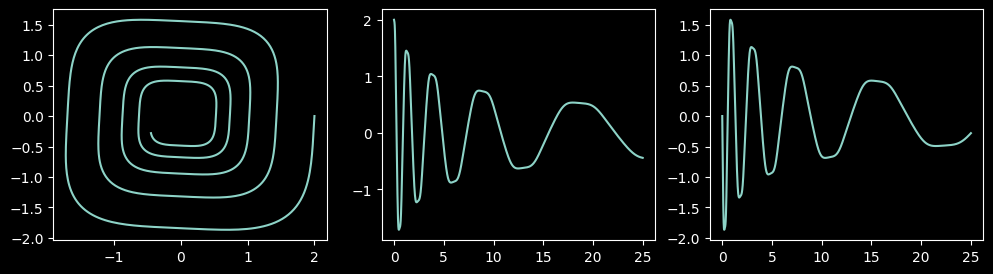

In [5]:
plt.figure(figsize=(12,3))
ax = plt.subplot(131)
ax.plot(xx1_cubic[0,:], xx1_cubic[1,:])
ax = plt.subplot(132)
ax.plot(times, xx1_cubic[0,:])
ax = plt.subplot(133)
ax.plot(times, xx1_cubic[1,:])

In [6]:
name = "data/lineal_oscillator/"
os.makedirs(name,exist_ok=True)
np.save(name+"{}_{}_{}".format(ti,tf,dt), xx1)

In [7]:
name = "data/cubic_oscillator/"
os.makedirs(name,exist_ok=True)
np.save(name+"{}_{}_{}".format(ti,tf,dt), xx1_cubic)

In [8]:
X = xx1.T
X_dot = np.array([f(xx,t) for xx,t in zip(xx1.T, times)])

In [10]:
p = 4
Cof = np.random.randn(p,2)

In [11]:
#Th = {'1':X,'3': X**3}
#Th_value = np.concatenate(list(Th.values()), axis=-1)
Th_value = np.concatenate([X, X**3], axis=-1)

In [12]:
XSindy_dot = Th_value.dot(Cof)

In [13]:
from sklearn import linear_model

In [14]:
lin_mod = linear_model.Lasso(alpha=0.01)

In [15]:
lasso_model = lin_mod.fit(Th_value, X_dot)

In [16]:
lasso_model.coef_.T.shape

(4, 2)

In [17]:
Th_value.dot(lasso_model.coef_.T) - X_dot

array([[-0.01739915,  0.00363951],
       [-0.01640558,  0.00286343],
       [-0.01539118,  0.00210407],
       ...,
       [ 0.00476392,  0.00854783],
       [ 0.00485005,  0.00849505],
       [ 0.00493562,  0.00844147]])

In [19]:
lasso_model.coef_

array([[-0.05616893,  1.95654458, -0.01313266,  0.01264522],
       [-1.9585186 , -0.05691093, -0.00991541, -0.01141384]])

(5000, 4)

In [29]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class RecurrentCell(torch.nn.Module):
    def __init__(self, dt=0.001):
        super(RecurrentCell, self).__init__()
        self.params = torch.nn.Parameter(data = torch.tensor([11, 8/3, 28],dtype=torch.float32, requires_grad=True))
        self.dt = dt

    def forward(self, input_data, hidden_state):
        sigma, beta, rho = self.params
        x,y,z = hidden_state
        dx, dy, dz = sigma*(y-x), x*(rho-z) -y, x*y - beta*z
        return torch.stack([x+dx*self.dt, y+dy*self.dt, z+dz*self.dt])

class RecurrentNetwork(nn.Module):
    def __init__(self,dt=0.001):
        super(RecurrentNetwork, self).__init__()
        self.RCell = RecurrentCell(dt=dt)

    def forward(self, input):
        outputs = []
        h_t = torch.tensor([-8,7,27],dtype=torch.float32)
        for i, input_t in enumerate(input):
            h_t = self.RCell(None, h_t)
            outputs += [h_t]
        
        outputs = torch.stack(outputs)
        return outputs